In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import os

In [3]:
# ============================================================
# Load raw data
# ============================================================
df_weekly_cn = pd.read_csv("Project/Data/China/Weekly Market Information of Domestic Index165542650/IDX_Idxtrdweek.csv")
df_index_cn  = pd.read_csv("Project/Data/China/Index Profile170027150/IDX_Idxinfo.csv")

# Ensure index code is the same type in both tables
df_weekly_cn["Indexcd"] = df_weekly_cn["Indexcd"].astype(str)
df_index_cn["Indexcd"]  = df_index_cn["Indexcd"].astype(str)

/var/folders/wp/k5t4pl853ng8y6kktqkmy3n80000gn/T/ipykernel_68867/4064318882.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weekly_cn = pd.read_csv("Project/Data/China/Weekly Market Information of Domestic Index165542650/IDX_Idxtrdweek.csv")


In [4]:
# ============================================================
# Read and merge all yearly US index files (2005–2025)
# ============================================================
csv_files = [
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2005.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2006.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2007.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2008.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2009.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2010.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2011.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2012.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2013.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2014.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2015.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2016.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2017.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2018.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2019.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2020.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2021.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2022.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2023.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2024.csv",
    "Project/Data/USA/Combined/TRDA_Gidxtrd_2025.csv",
]

all_dfs_us = []
for fp in csv_files:
    df = pd.read_csv(fp)
    df["source_file"] = os.path.basename(fp)
    all_dfs_us.append(df)

merged_full_df_us = pd.concat(all_dfs_us, ignore_index=True)
out_merged_us = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv"
merged_full_df_us.to_csv(out_merged_us, index=False)
print(f"✅ Merged {len(csv_files)} files → {out_merged_us}")
print(f"   Total rows: {len(merged_full_df_us):,}")


✅ Merged 21 files → Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_merged.csv
   Total rows: 7,157,595


In [5]:
# ============================================================
# Merge weekly quotes with index names
# ============================================================
merged_weekly_cn = pd.merge(
    df_weekly_cn,
    df_index_cn[["Indexcd", "Idxinfo01_en"]],   # only the columns we need
    on="Indexcd",
    how="left"
)

# Keep only relevant columns and rename for clarity
merged_weekly_cn = merged_weekly_cn[["Idxinfo01_en", "Indexcd", "Week", "Clsidx"]]
merged_weekly_cn.columns = ["EnglishName", "IndexCode", "Date", "Closing"]

display(merged_weekly_cn.head(10))

,EnglishName,IndexCode,Date,Closing
0,SSE Composite Index,000001,1991-01,131.44
1,SSE Composite Index,000001,1991-02,134.60
2,SSE Composite Index,000001,1991-03,134.24
3,SSE Composite Index,000001,1991-04,132.05
4,SSE Composite Index,000001,1991-05,129.51
5,SSE Composite Index,000001,1991-06,130.38
6,SSE Composite Index,000001,1991-07,132.53
7,SSE Composite Index,000001,1991-08,134.87
8,SSE Composite Index,000001,1991-09,132.53
9,SSE Composite Index,000001,1991-10,129.89


In [6]:
# index name for english name = x
index_name = "Transportation & Storage Index"
# Filter data for the specified index
index_data = merged_weekly_cn[merged_weekly_cn["EnglishName"] == index_name]
index_data

,EnglishName,IndexCode,Date,Closing
409655,Transportation & Storage Index,399160,2001-27,645.680
409656,Transportation & Storage Index,399160,2001-28,654.590
409657,Transportation & Storage Index,399160,2001-29,662.530
409658,Transportation & Storage Index,399160,2001-30,645.840
409659,Transportation & Storage Index,399160,2001-31,616.960
...,...,...,...,...
410236,Transportation & Storage Index,399160,2013-04,766.643
410237,Transportation & Storage Index,399160,2013-05,806.004
410238,Transportation & Storage Index,399160,2013-06,808.120
410239,Transportation & Storage Index,399160,2013-08,782.092


In [7]:
# ============================================================
# Keep only Fridays and normalize columns
# ============================================================
def keep_fridays(df: pd.DataFrame):
    """Detect date column, parse, and keep only Fridays."""
    date_col = None
    for cand in ["Trddt", "Date", "date", "DATE"]:
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        raise ValueError("No date column found (expected one of: Trddt, Date, date, DATE).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col])
    df = df[df[date_col].dt.weekday == 4].copy()  # 4 = Friday
    return df, date_col

friday_parts = []
rows_before, rows_after = 0, 0

for fp in csv_files:
    tmp = pd.read_csv(fp)
    rows_before += len(tmp)
    tmp, dt_col = keep_fridays(tmp)
    tmp["source_file"] = os.path.basename(fp)
    rows_after += len(tmp)
    friday_parts.append(tmp)
    print(f"✔ {os.path.basename(fp)}: {len(tmp):,} Friday rows")

friday_df = pd.concat(friday_parts, ignore_index=True)

# keep useful columns if they exist
keep_cols = [c for c in ["Indexcd", "IndexName", "Clsidx", dt_col, "source_file"] if c in friday_df.columns]
friday_df = friday_df[keep_cols]

out_fridays = "Project/Data/USA/Combined/TRDA_Gidxtrd_2005_2025_FRIDAYS_merged.csv"
friday_df.to_csv(out_fridays, index=False)

print("\n✅ Friday-only merge complete.")
print(f"   Rows before filter: {rows_before:,}")
print(f"   Rows after filter:  {rows_after:,}")
print(f"   Output: {out_fridays}")


✔ TRDA_Gidxtrd_2005.csv: 39,874 Friday rows
✔ TRDA_Gidxtrd_2006.csv: 77,199 Friday rows
✔ TRDA_Gidxtrd_2007.csv: 74,692 Friday rows
✔ TRDA_Gidxtrd_2008.csv: 109,679 Friday rows
✔ TRDA_Gidxtrd_2009.csv: 121,857 Friday rows
✔ TRDA_Gidxtrd_2010.csv: 116,933 Friday rows
✔ TRDA_Gidxtrd_2011.csv: 120,666 Friday rows
✔ TRDA_Gidxtrd_2012.csv: 122,046 Friday rows
✔ TRDA_Gidxtrd_2013.csv: 122,470 Friday rows
✔ TRDA_Gidxtrd_2014.csv: 113,143 Friday rows
✔ TRDA_Gidxtrd_2015.csv: 112,220 Friday rows
✔ TRDA_Gidxtrd_2016.csv: 115,264 Friday rows
✔ TRDA_Gidxtrd_2017.csv: 104,535 Friday rows
✔ TRDA_Gidxtrd_2018.csv: 40,131 Friday rows
✔ TRDA_Gidxtrd_2019.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2020.csv: 1,814 Friday rows
✔ TRDA_Gidxtrd_2021.csv: 1,887 Friday rows
✔ TRDA_Gidxtrd_2022.csv: 1,888 Friday rows
✔ TRDA_Gidxtrd_2023.csv: 1,885 Friday rows
✔ TRDA_Gidxtrd_2024.csv: 1,815 Friday rows
✔ TRDA_Gidxtrd_2025.csv: 1,517 Friday rows

✅ Friday-only merge complete.
   Rows before filter: 7,157,595
   Rows a

In [8]:
us_cn_mapping = {
    "NASDAQ Health Care": [
        "CSI 800 Pharmaceuticals and Biotechnology Index",
        "CSI Health Care 100 Index",
        "Pharmaceutical & Biological Index",
        "SSE STAR Biology and Medicine Index"
    ],
    "NQ Biotechnology": [
        "SSE STAR Biology and Medicine Index",
        "CSI WIND Biotechnology Index"
    ],
    "NQ Computer": [
        "SSE Information Technology Sector index",
        "CSI Information Technology index",
        "SZSE Information Technology Sector Index",
        "ELECTRONIC EQUIPMENT INDEX",
        "Information equipment"
    ],
    "NQ Internet": [
        "SSE Information Technology Sector index",
        "CSI Information Technology index",
        "SZSE Information Technology Sector Index",
        "ELECTRONIC EQUIPMENT INDEX",
        "Information equipment"
    ],
    "NQ Industrial": [
        "SSE Upstream Industry Index",
        "SSE Midstream Industry Index",
        "SSE Downstream Industry Index",
        "CSI Midstream Manufacturing Industry Index"
    ],
    "NQ Transportation": [
        "Transportation & Storage Index",
        "CSI China Mainland Transportation index"
    ]
}


In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# ------------------------------------------------------------
# 1) US weekly (friday_df): make YearWeek from actual dates
# ------------------------------------------------------------
for cand in ["Date", "Trddt", "date", "DATE"]:
    if cand in friday_df.columns:
        us_date_col = cand
        break
else:
    raise ValueError("No date column found in friday_df")

friday_df[us_date_col] = pd.to_datetime(friday_df[us_date_col], errors="coerce")
iso = friday_df[us_date_col].dt.isocalendar()
friday_df["YearWeek"] = iso.year.astype(str) + "-" + iso.week.astype(str).str.zfill(2)

# ------------------------------------------------------------
# 2) CN weekly (merged_weekly_us): already "YYYY-WW"
# ------------------------------------------------------------
merged_weekly_cn["YearWeek"] = merged_weekly_cn["Date"].astype(str)

# ------------------------------------------------------------
# 3) mapping US -> list of CN indices you want to test against
# ------------------------------------------------------------


# ------------------------------------------------------------
# helper: compute weekly log returns
# ------------------------------------------------------------
def compute_log_returns(df, price_col, out_col):
    df = df.sort_values("YearWeek").copy()
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df[out_col] = np.log(df[price_col]).diff()
    return df[["YearWeek", out_col]].dropna()

# ------------------------------------------------------------
# helper: extract best (smallest) p-value from statsmodels result
# ------------------------------------------------------------
def best_granger_p(two_col_array: np.ndarray, maxlag: int) -> float:
    """
    two_col_array[:,0] = dependent
    two_col_array[:,1] = potential cause
    returns min p-value across lags
    """
    res = grangercausalitytests(two_col_array, maxlag=maxlag, verbose=False)
    pvals = []
    for lag, out in res.items():
        # out is usually a tuple: (testdict, extra)
        if isinstance(out, tuple):
            testdict = out[0]
        else:
            testdict = out
        if "ssr_ftest" in testdict:
            pvals.append(testdict["ssr_ftest"][1])
    return min(pvals) if pvals else np.nan

# ------------------------------------------------------------
# 4) run over all pairs
# ------------------------------------------------------------
max_lag = 4
rows = []

for us_name, cn_names in us_cn_mapping.items():
    # US slice
    us_sub = friday_df[friday_df["IndexName"] == us_name].copy()
    if us_sub.empty:
        print(f"⚠️ US index '{us_name}' not found.")
        continue
    us_ret = compute_log_returns(us_sub, "Clsidx", "US_Ret")

    for cn_name in cn_names:
        cn_sub = merged_weekly_cn[merged_weekly_cn["EnglishName"] == cn_name].copy()
        if cn_sub.empty:
            print(f"⚠️ CN index '{cn_name}' not found.")
            continue
        cn_ret = compute_log_returns(cn_sub, "Closing", "CN_Ret")

        # align by YearWeek
        merged = pd.merge(us_ret, cn_ret, on="YearWeek", how="inner").dropna()
        if len(merged) < max_lag + 10:
            print(f"⚠️ {us_name} ↔ {cn_name}: too few common weeks ({len(merged)}).")
            continue

        data = merged[["US_Ret", "CN_Ret"]].to_numpy()


        rows.append(
            {
                "US_Index": us_name,
                "CN_Index": cn_name,
                "n_obs": len(merged)
            }
        )

# results table
granger_results = pd.DataFrame(rows)
display(granger_results)


,US_Index,CN_Index,n_obs
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631
1,NASDAQ Health Care,CSI Health Care 100 Index,1106
2,NASDAQ Health Care,Pharmaceutical & Biological Index,368
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,284
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,284
5,NQ Biotechnology,CSI WIND Biotechnology Index,514
6,NQ Computer,SSE Information Technology Sector index,825
7,NQ Computer,CSI Information Technology index,1606
8,NQ Computer,SZSE Information Technology Sector Index,1018
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,394


In [20]:
# Keep only pairs with at least 350 overlapping weeks.
filtered = granger_results[
    (granger_results["n_obs"] >= 350)
].copy()

# Reset index for nicer display / downstream operations
filtered = filtered.reset_index(drop=True)
display(filtered)


,US_Index,CN_Index,n_obs
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,631
1,NASDAQ Health Care,CSI Health Care 100 Index,1106
2,NASDAQ Health Care,Pharmaceutical & Biological Index,368
3,NQ Biotechnology,CSI WIND Biotechnology Index,514
4,NQ Computer,SSE Information Technology Sector index,825
5,NQ Computer,CSI Information Technology index,1606
6,NQ Computer,SZSE Information Technology Sector Index,1018
7,NQ Computer,ELECTRONIC EQUIPMENT INDEX,394
8,NQ Computer,Information equipment,544
9,NQ Internet,SSE Information Technology Sector index,659


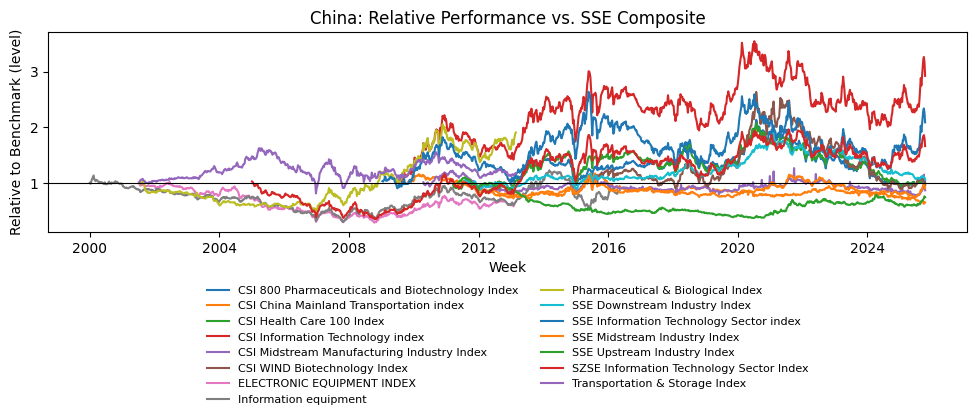

In [21]:
# Benchmark visualization of Chinese indices vs. SSE Composite Index

# -----------------------------
# Prepare list of CN indices
# -----------------------------
# Only the Chinese indices that appear in the filtered results are plotted.
cn_indices = sorted(filtered["CN_Index"].unique().tolist())

if len(cn_indices) == 0:
    raise ValueError("No Chinese indices found in 'filtered'. Check granger_results and the n_obs threshold.")

# -----------------------------
# Prepare Chinese weekly data
# -----------------------------
cn_df = merged_weekly_cn.copy()

# Ensure numeric closing values and mark non-positive as NaN
cn_df["Closing"] = pd.to_numeric(cn_df["Closing"], errors="coerce")
cn_df.loc[cn_df["Closing"] <= 0, "Closing"] = np.nan

# Convert ISO week string "YYYY-WW" to a concrete week-start date (Monday)
def iso_week_to_date(s):
    year, week = s.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)

# Create WeekStart column used as time index
cn_df["WeekStart"] = cn_df["Date"].astype(str).apply(iso_week_to_date)

# Keep only rows for the relevant Chinese indices
cn_df = cn_df[cn_df["EnglishName"].isin(cn_indices)].copy()

# If multiple entries per (index, week) exist, aggregate by mean closing price
cn_df = (
    cn_df
    .groupby(["EnglishName", "WeekStart"], as_index=False)["Closing"]
    .mean()
    .sort_values(["EnglishName", "WeekStart"])
)

# Compute weekly log returns per index
cn_df["LogReturn"] = np.log(cn_df["Closing"]).groupby(cn_df["EnglishName"]).diff()

# Pivot to get weeks × indices matrix of returns
cn_pivot = cn_df.pivot(index="WeekStart", columns="EnglishName", values="LogReturn").sort_index()

# -----------------------------
# Add SSE Composite Index as benchmark if missing
# -----------------------------
benchmark_name = "SSE Composite Index"
if benchmark_name not in cn_pivot.columns:
    extra = merged_weekly_cn[merged_weekly_cn["EnglishName"] == benchmark_name].copy()
    extra["Closing"] = pd.to_numeric(extra["Closing"], errors="coerce")
    extra["WeekStart"] = extra["Date"].astype(str).apply(iso_week_to_date)
    extra = (
        extra.groupby(["WeekStart"], as_index=False)["Closing"]
        .mean()
        .sort_values("WeekStart")
    )
    extra["LogReturn"] = np.log(extra["Closing"]).diff()
    cn_pivot[benchmark_name] = extra.set_index("WeekStart")["LogReturn"]

# Keep only weeks where the benchmark has data (aligns all series to benchmark availability)
cn_pivot = cn_pivot.dropna(subset=[benchmark_name])

# -----------------------------
# Plot relative performance vs. benchmark
# -----------------------------
plt.figure(figsize=(10, 5))

plotted_any = False
for col in cn_indices:
    # Skip benchmark column and any index not in the pivot (e.g., due to missing data)
    if col == benchmark_name or col not in cn_pivot:
        continue
    pair = cn_pivot[[benchmark_name, col]].dropna()
    if pair.empty:
        continue

    # cumulative excess log return -> convert to level relative to 1
    ex_ret = (pair[col] - pair[benchmark_name]).cumsum()
    rel_series = np.exp(ex_ret)

    plt.plot(rel_series.index, rel_series.values, label=f"{col}")
    plotted_any = True

if not plotted_any:
    raise ValueError("No series plotted: check that cn_indices exist in merged_weekly_cn and have enough data.")

plt.axhline(1.0, color="black", linewidth=0.8)
plt.title("China: Relative Performance vs. SSE Composite", fontsize=12)
plt.ylabel("Relative to Benchmark (level)")
plt.xlabel("Week")

# Legend below the plot, centered
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=2,
    fontsize=8,
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 1])  # leave space for the legend below the figure
plt.show()

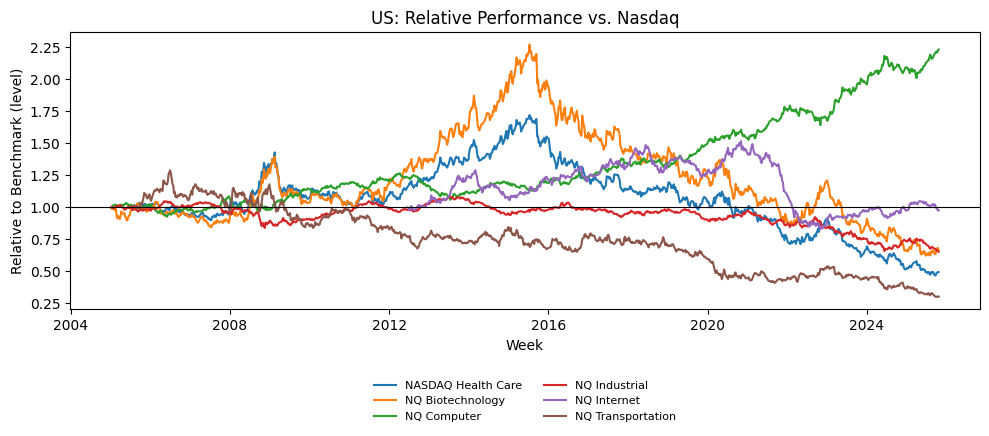

In [22]:
# Visualization of US indices vs. Nasdaq Benchmark

# List of unique US indices to plot
us_indices = sorted(filtered["US_Index"].unique().tolist())

if len(us_indices) == 0:
    raise ValueError("No US indices found in 'filtered'. Check granger_results and the filtering thresholds.")

# -----------------------------
# 2) Prepare US weekly data
# -----------------------------
us_df = friday_df.copy()

# Ensure numeric price column and drop non-positive values
us_df["Clsidx"] = pd.to_numeric(us_df["Clsidx"], errors="coerce")
us_df.loc[us_df["Clsidx"] <= 0, "Clsidx"] = np.nan

# Convert YearWeek string "YYYY-WW" to a concrete week-start date (Monday)
def yearweek_to_date(s):
    year, week = s.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)

us_df["WeekStart"] = us_df["YearWeek"].astype(str).apply(yearweek_to_date)

# Keep only required indices: all filtered US indices plus the benchmark
need_names = set(us_indices) | {benchmark_name}
us_df = us_df[us_df["IndexName"].isin(need_names)].copy()

# Aggregate multiple entries per (IndexName, WeekStart) by mean
us_df = (
    us_df
    .groupby(["IndexName", "WeekStart"], as_index=False)["Clsidx"]
    .mean()
    .sort_values(["IndexName", "WeekStart"])
)

# Compute weekly log returns per index
us_df["LogReturn"] = np.log(us_df["Clsidx"]).groupby(us_df["IndexName"]).diff()

# Pivot to weeks × indices
us_pivot = us_df.pivot(index="WeekStart", columns="IndexName", values="LogReturn").sort_index()

# -----------------------------
# 3) Ensure benchmark is present
# -----------------------------
benchmark_name = "Nasdaq"
if benchmark_name not in us_pivot.columns:
    # try to extract benchmark from friday_df (same source)
    extra = friday_df[friday_df["IndexName"] == benchmark_name].copy()
    if extra.empty:
        raise ValueError(f"Benchmark '{benchmark_name}' not found in friday_df. Please ensure benchmark data are available.")
    extra["Clsidx"] = pd.to_numeric(extra["Clsidx"], errors="coerce")
    extra["WeekStart"] = extra["YearWeek"].astype(str).apply(yearweek_to_date)
    extra = (
        extra.groupby(["WeekStart"], as_index=False)["Clsidx"]
        .mean()
        .sort_values("WeekStart")
    )
    extra["LogReturn"] = np.log(extra["Clsidx"]).diff()
    us_pivot[benchmark_name] = extra.set_index("WeekStart")["LogReturn"]

# Keep only weeks with benchmark data to align all series
us_pivot = us_pivot.dropna(subset=[benchmark_name])

# -----------------------------
# 4) Plot relative performance vs. benchmark
# -----------------------------
plt.figure(figsize=(10, 5))

plotted_any = False
for name in us_indices:
    # Skip benchmark itself and any names not present in the pivot
    if name == benchmark_name or name not in us_pivot:
        continue
    pair = us_pivot[[benchmark_name, name]].dropna()
    if pair.empty:
        continue

    # cumulative excess log return -> convert to level relative to 1
    ex_ret = (pair[name] - pair[benchmark_name]).cumsum()
    rel_series = np.exp(ex_ret)

    plt.plot(rel_series.index, rel_series.values, label=f"{name}")
    plotted_any = True

if not plotted_any:
    raise ValueError("No series plotted: check that us_indices exist in friday_df and have enough data.")

plt.axhline(1.0, color="black", linewidth=0.8)
plt.title(f"US: Relative Performance vs. {benchmark_name}", fontsize=12)
plt.ylabel("Relative to Benchmark (level)")
plt.xlabel("Week")

# Legend below the plot; adjust ncol depending on the number of series
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=2,
    fontsize=8,
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 1])  # leave space for the legend
plt.show()

In [23]:
def yearweek_to_monday(yearweek: str) -> pd.Timestamp:
    year, week = yearweek.split("-")
    return pd.Timestamp.fromisocalendar(int(year), int(week), 1)  # Monday of the ISO week

def make_pair_timeseries(
    friday_df: pd.DataFrame,
    merged_weekly_cn: pd.DataFrame,
    us_name: str,
    cn_name: str,
):
    """
    Takes a U.S. index name (as in friday_df['IndexName'])
    and a Chinese index name (as in merged_weekly_cn['EnglishName'])
    and returns a weekly, merged DataFrame of:
        Date | US_Close | CN_Close | US_Ret | CN_Ret
    Only overlapping weeks are included.
    """

    # --- U.S. data processing ---
    us_sub = friday_df[friday_df["IndexName"] == us_name].copy()
    if us_sub.empty:
        raise ValueError(f"US index '{us_name}' not found in friday_df.")
    us_sub = us_sub[["YearWeek", "Clsidx"]].copy()
    us_sub["Date"] = us_sub["YearWeek"].astype(str).apply(yearweek_to_monday)
    us_sub = us_sub.sort_values("Date")
    us_sub["US_Close"] = pd.to_numeric(us_sub["Clsidx"], errors="coerce")
    us_sub = us_sub.dropna(subset=["US_Close"])

    # --- China data processing ---
    cn_sub = merged_weekly_cn[merged_weekly_cn["EnglishName"] == cn_name].copy()
    if cn_sub.empty:
        raise ValueError(f"CN index '{cn_name}' not found in merged_weekly_cn.")

    # Ensure a YearWeek column exists
    if "YearWeek" not in cn_sub.columns:
        cn_sub["YearWeek"] = cn_sub["Date"].astype(str)

    cn_sub = cn_sub[["YearWeek", "Closing"]].copy()
    cn_sub["Date"] = cn_sub["YearWeek"].astype(str).apply(yearweek_to_monday)
    cn_sub = cn_sub.sort_values("Date")
    cn_sub["CN_Close"] = pd.to_numeric(cn_sub["Closing"], errors="coerce")
    cn_sub = cn_sub.dropna(subset=["CN_Close"])

    # --- Merge on common weeks ---
    data = pd.merge(
        us_sub[["Date", "US_Close"]],
        cn_sub[["Date", "CN_Close"]],
        on="Date",
        how="inner"
    ).sort_values("Date")

    # Log returns
    data["US_Ret"] = np.log(data["US_Close"]).diff()
    data["CN_Ret"] = np.log(data["CN_Close"]).diff()
    data = data.dropna(subset=["US_Ret", "CN_Ret"]).reset_index(drop=True)

    return data

In [32]:
# -----------------------------
# Parameters
# -----------------------------
MAX_LAG = 26

def granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG):
    """
    Expects a DataFrame produced by make_pair_timeseries with columns:
    Date, US_Close, CN_Close, US_Ret, CN_Ret
    Returns a dict of p-values for CN -> US for lags 1..maxlag.
    """
    df = pair_df[["US_Ret", "CN_Ret"]].dropna()
    # arrange columns: dependent first (US), potential cause second (CN)
    arr = df[["US_Ret", "CN_Ret"]].to_numpy()
    res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        # store ssr F-test p-value
        lag_p[lag] = testdict["ssr_ftest"][1]
    return lag_p


def granger_us_to_cn_from_pair(pair_df, maxlag=MAX_LAG):
    """
    Expects a DataFrame produced by make_pair_timeseries with columns:
    Date, US_Close, CN_Close, US_Ret, CN_Ret
    Returns a dict of p-values for US -> CN for lags 1..maxlag.
    """
    df = pair_df[["CN_Ret", "US_Ret"]].dropna()
    # arrange columns: dependent first (CN), potential cause second (US)
    arr = df[["CN_Ret", "US_Ret"]].to_numpy()
    res = grangercausalitytests(arr, maxlag=maxlag, verbose=False)
    lag_p = {}
    for lag, out in res.items():
        testdict = out[0] if isinstance(out, tuple) else out
        # store ssr F-test p-value
        lag_p[lag] = testdict["ssr_ftest"][1]
    return lag_p


# -----------------------------
# Build list of pairs from 'filtered'
# -----------------------------
# 'filtered' should contain the pairs of interest (columns: 'US_Index', 'CN_Index', ...)
pairs = filtered[["US_Index", "CN_Index"]].drop_duplicates().reset_index(drop=True)

rows_cn_to_us = []
rows_us_to_cn = []


# Define the shared styling function
def highlight_pvals(val):
    """Highlights p-values based on significance thresholds."""
    if pd.isna(val):
        return ""
    if val < 0.05:
        return "background-color: #a8e6a1"  # green
    elif val < 0.1:
        return "background-color: #fff3b0"  # yellow


# ====================================================================================
# Iterate through pairs and compute Granger Causality for BOTH directions
# ====================================================================================

for _, pr in pairs.iterrows():
    us_name = pr["US_Index"]
    cn_name = pr["CN_Index"]

    # 1) build pair timeseries (only once per pair)
    try:
        pair_df = make_pair_timeseries(
            friday_df,
            merged_weekly_cn,
            us_name=us_name,
            cn_name=cn_name
        )
    except Exception as e:
        # If timeseries construction fails, record the error for both directions
        error_row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "error": f"make_pair_timeseries error: {e}"
        }
        rows_cn_to_us.append({"direction": "CN→US", **error_row})
        rows_us_to_cn.append({"direction": "US→CN", **error_row})
        continue

    # skip empty or too-short series
    if pair_df is None or pair_df.empty:
        error_row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "error": "no overlapping observations"
        }
        rows_cn_to_us.append({"direction": "CN→US", **error_row})
        rows_us_to_cn.append({"direction": "US→CN", **error_row})
        continue


    # --- A) CN -> US ---
    try:
        lag_p = granger_cn_to_us_from_pair(pair_df, maxlag=MAX_LAG)
        # assemble output row
        row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "CN→US",
        }
        for lag in range(1, MAX_LAG + 1):
            row[f"Lag_{lag}"] = lag_p.get(lag, np.nan)
        row["n_obs"] = len(pair_df)
        rows_cn_to_us.append(row)

    except Exception as e:
        # record error (e.g., numerical issues, insufficient obs for requested maxlag)
        rows_cn_to_us.append({
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "CN→US",
            "error": f"granger error: {e}"
        })


    # --- B) US -> CN ---
    try:
        lag_p = granger_us_to_cn_from_pair(pair_df, maxlag=MAX_LAG)
        # assemble output row
        row = {
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "US→CN",
        }
        for lag in range(1, MAX_LAG + 1):
            row[f"Lag_{lag}"] = lag_p.get(lag, np.nan)
        row["n_obs"] = len(pair_df)
        rows_us_to_cn.append(row)

    except Exception as e:
        # record error (e.g., numerical issues, insufficient obs for requested maxlag)
        rows_us_to_cn.append({
            "US_Index": us_name,
            "CN_Index": cn_name,
            "direction": "US→CN",
            "error": f"granger error: {e}"
        })


# 4) Create two separate DataFrames
granger_cn_to_us_df = pd.DataFrame(rows_cn_to_us)
granger_us_to_cn_df = pd.DataFrame(rows_us_to_cn)


# 5) Styling Function for Reusability
def apply_granger_styling(df):
    """Applies conditional formatting to the Granger DataFrame."""
    lag_cols = [c for c in df.columns if c.startswith("Lag_")]

    # Create a column for the minimum p-value for styling/sorting
    if lag_cols:
        df["min_p_value"] = df[lag_cols].min(axis=1)
        styled = (
            df
            .style
            .applymap(highlight_pvals, subset=lag_cols)
            .background_gradient(subset=["min_p_value"], cmap="RdYlGn_r")
            .format("{:.4f}", subset=lag_cols + ["min_p_value"])
        )
    else:
        # Handle case where only error columns exist (e.g., if MAX_LAG=0)
        styled = df.style

    return styled


# 6) Apply Styling to both DataFrames
styled_cn_to_us = apply_granger_styling(granger_cn_to_us_df)
styled_us_to_cn = apply_granger_styling(granger_us_to_cn_df)

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/ts

In [33]:
print("--- Granger Causality Results: CN -> US ---")
display(styled_cn_to_us) 

--- Granger Causality Results: CN -> US ---


,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,n_obs,min_p_value
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,CN→US,0.0707,0.1499,0.1442,0.2654,0.2466,0.3645,0.4341,0.5027,0.5686,0.5191,0.6228,0.6852,0.4164,0.4352,0.4816,0.5390,0.6217,0.3745,0.4495,0.5317,0.5223,0.5279,0.6009,0.6862,0.7425,0.7413,631,0.0707
1,NASDAQ Health Care,CSI Health Care 100 Index,CN→US,0.7557,0.2910,0.4653,0.5796,0.6649,0.0282,0.0421,0.0777,0.1147,0.0361,0.0612,0.0166,0.0228,0.0291,0.0384,0.0377,0.0312,0.0327,0.0277,0.0346,0.0480,0.0401,0.0544,0.0851,0.0874,0.1066,1106,0.0166
2,NASDAQ Health Care,Pharmaceutical & Biological Index,CN→US,0.7693,0.8463,0.9339,0.9421,0.9812,0.9927,0.9978,0.9769,0.9815,0.9779,0.9918,0.9260,0.9113,0.9405,0.8333,0.8316,0.7867,0.7783,0.8298,0.8284,0.8255,0.8514,0.7710,0.7367,0.7445,0.7256,368,0.7256
3,NQ Biotechnology,CSI WIND Biotechnology Index,CN→US,0.1764,0.3570,0.5447,0.6772,0.4856,0.4864,0.4130,0.3761,0.2993,0.3340,0.3808,0.4355,0.2692,0.0929,0.1317,0.2345,0.2542,0.2752,0.2709,0.2414,0.2907,0.3280,0.3910,0.4082,0.3534,0.3652,514,0.0929
4,NQ Computer,SSE Information Technology Sector index,CN→US,0.2574,0.4582,0.2695,0.4289,0.5634,0.7139,0.8684,0.6722,0.7338,0.7193,0.7958,0.8257,0.8334,0.8808,0.8549,0.8636,0.8929,0.9201,0.9527,0.9690,0.9695,0.8674,0.8298,0.8459,0.8920,0.8801,825,0.2574
5,NQ Computer,CSI Information Technology index,CN→US,0.9955,0.5719,0.7728,0.9140,0.9644,0.2333,0.3271,0.3608,0.4584,0.6457,0.7300,0.7697,0.8314,0.8726,0.9108,0.8573,0.8962,0.8886,0.9196,0.9172,0.9409,0.9283,0.9485,0.9615,0.9732,0.9271,1605,0.2333
6,NQ Computer,SZSE Information Technology Sector Index,CN→US,0.8841,0.7531,0.6325,0.3966,0.4681,0.5494,0.6180,0.4014,0.5031,0.5489,0.4130,0.3508,0.2251,0.2857,0.1876,0.1945,0.1631,0.1728,0.1792,0.2421,0.1753,0.2027,0.2249,0.2113,0.1801,0.1746,1018,0.1631
7,NQ Computer,ELECTRONIC EQUIPMENT INDEX,CN→US,0.5735,0.6601,0.8055,0.3308,0.5579,0.6566,0.5570,0.5264,0.6367,0.6839,0.3776,0.3025,0.2805,0.2559,0.1548,0.1657,0.0866,0.0849,0.1037,0.1092,0.1172,0.1157,0.1467,0.0795,0.1170,0.1356,394,0.0795
8,NQ Computer,Information equipment,CN→US,0.8308,0.9236,0.9784,0.6598,0.7883,0.7544,0.4619,0.5101,0.6026,0.6459,0.2728,0.2938,0.1716,0.1769,0.0915,0.0918,0.0428,0.0316,0.0294,0.0432,0.0565,0.0575,0.0747,0.0289,0.0418,0.0446,544,0.0289
9,NQ Internet,SSE Information Technology Sector index,CN→US,0.2854,0.6017,0.6895,0.8309,0.8623,0.5561,0.6901,0.6055,0.6586,0.7072,0.7192,0.7886,0.7974,0.7889,0.8095,0.8492,0.8865,0.9047,0.9381,0.9454,0.9644,0.9139,0.8697,0.8954,0.9055,0.8537,659,0.2854


In [34]:
print("\n--- Granger Causality Results: US -> CN ---")
display(styled_us_to_cn)


--- Granger Causality Results: US -> CN ---


,US_Index,CN_Index,direction,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24,Lag_25,Lag_26,n_obs,min_p_value
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,US→CN,0.0757,0.2172,0.4017,0.5230,0.4598,0.5483,0.6323,0.7186,0.6467,0.7042,0.3886,0.1938,0.1420,0.1587,0.2208,0.2596,0.2737,0.2991,0.3209,0.3785,0.1225,0.1465,0.1543,0.1511,0.1801,0.2275,631,0.0757
1,NASDAQ Health Care,CSI Health Care 100 Index,US→CN,0.5775,0.2200,0.3875,0.3855,0.4710,0.5982,0.7171,0.6056,0.6560,0.6389,0.4172,0.0716,0.0877,0.1086,0.1477,0.1515,0.1065,0.1282,0.1447,0.1883,0.1656,0.0959,0.1487,0.1254,0.1354,0.0232,1106,0.0232
2,NASDAQ Health Care,Pharmaceutical & Biological Index,US→CN,0.1291,0.2380,0.2017,0.3169,0.2976,0.1993,0.2938,0.3545,0.4260,0.1834,0.2404,0.2969,0.3252,0.3515,0.3669,0.3511,0.4080,0.4772,0.5959,0.4942,0.5187,0.6004,0.5991,0.6422,0.7151,0.6870,368,0.1291
3,NQ Biotechnology,CSI WIND Biotechnology Index,US→CN,0.3570,0.6176,0.7146,0.7442,0.5163,0.4642,0.5224,0.5457,0.6078,0.6690,0.6721,0.6411,0.6508,0.7236,0.8022,0.8186,0.6106,0.6180,0.6782,0.7366,0.3924,0.4371,0.4365,0.4920,0.5110,0.5704,514,0.3570
4,NQ Computer,SSE Information Technology Sector index,US→CN,0.0078,0.0031,0.0036,0.0094,0.0082,0.0106,0.0101,0.0194,0.0092,0.0153,0.0245,0.0337,0.0513,0.0662,0.1012,0.1361,0.0788,0.0440,0.0528,0.0720,0.1066,0.1226,0.0867,0.1055,0.1071,0.0505,825,0.0031
5,NQ Computer,CSI Information Technology index,US→CN,0.9261,0.0036,0.0105,0.0000,0.0001,0.0003,0.0006,0.0010,0.0020,0.0006,0.0012,0.0004,0.0007,0.0004,0.0008,0.0010,0.0016,0.0006,0.0009,0.0008,0.0014,0.0016,0.0025,0.0016,0.0024,0.0031,1605,0.0000
6,NQ Computer,SZSE Information Technology Sector Index,US→CN,0.0001,0.0000,0.0001,0.0003,0.0003,0.0003,0.0002,0.0001,0.0002,0.0001,0.0001,0.0002,0.0002,0.0004,0.0006,0.0005,0.0002,0.0002,0.0002,0.0005,0.0008,0.0009,0.0009,0.0012,0.0018,0.0004,1018,0.0000
7,NQ Computer,ELECTRONIC EQUIPMENT INDEX,US→CN,0.0000,0.0002,0.0005,0.0016,0.0018,0.0019,0.0040,0.0026,0.0050,0.0051,0.0079,0.0125,0.0153,0.0350,0.0430,0.0294,0.0377,0.0534,0.0534,0.0689,0.0927,0.1351,0.1679,0.1800,0.2624,0.1938,394,0.0000
8,NQ Computer,Information equipment,US→CN,0.0005,0.0019,0.0064,0.0156,0.0210,0.0230,0.0473,0.0413,0.0654,0.0464,0.0650,0.0691,0.0381,0.0758,0.0962,0.0932,0.1148,0.1427,0.1803,0.1975,0.2695,0.3730,0.4334,0.4684,0.5725,0.5330,544,0.0005
9,NQ Internet,SSE Information Technology Sector index,US→CN,0.2156,0.0289,0.0429,0.0429,0.0616,0.0867,0.0535,0.0783,0.0657,0.0694,0.0961,0.1238,0.1970,0.2253,0.2816,0.3353,0.2496,0.2575,0.2518,0.2380,0.2771,0.3265,0.2497,0.2624,0.1871,0.0961,659,0.0289


In [17]:
def get_overlap_period(friday_df, merged_weekly_cn, us_name, cn_name):
    pair = make_pair_timeseries(
        friday_df, merged_weekly_cn,
        us_name=us_name,
        cn_name=cn_name
    )
    if pair is None or pair.empty:
        return None
    
    start = pair["Date"].min().date()
    end   = pair["Date"].max().date()
    return start, end, len(pair)

overlaps = []

for us_name, cn_list in us_cn_mapping.items():
    for cn_name in cn_list:
        try:
            result = get_overlap_period(friday_df, merged_weekly_cn, us_name, cn_name)
            if result:
                start, end, n = result
                overlaps.append({
                    "US_Index": us_name,
                    "CN_Index": cn_name,
                    "Overlap_Start": start,
                    "Overlap_End": end,
                    "n_weeks": n
                })
        except Exception:
            continue

overlap_df = pd.DataFrame(overlaps)
display(overlap_df)


,US_Index,CN_Index,Overlap_Start,Overlap_End,n_weeks
0,NASDAQ Health Care,CSI 800 Pharmaceuticals and Biotechnology Index,2012-12-24,2025-10-13,631
1,NASDAQ Health Care,CSI Health Care 100 Index,2011-03-14,2025-10-13,1106
2,NASDAQ Health Care,Pharmaceutical & Biological Index,2005-08-08,2013-02-25,368
3,NASDAQ Health Care,SSE STAR Biology and Medicine Index,2020-01-06,2025-10-13,284
4,NQ Biotechnology,SSE STAR Biology and Medicine Index,2020-01-06,2025-10-13,284
5,NQ Biotechnology,CSI WIND Biotechnology Index,2015-05-11,2025-10-13,514
6,NQ Computer,SSE Information Technology Sector index,2009-01-12,2025-10-13,825
7,NQ Computer,CSI Information Technology index,2009-07-06,2025-10-13,1605
8,NQ Computer,SZSE Information Technology Sector Index,2005-01-10,2025-10-13,1018
9,NQ Computer,ELECTRONIC EQUIPMENT INDEX,2005-01-10,2013-02-25,394
